<a href="https://colab.research.google.com/github/sdhar2020/WebsiteCode/blob/main/5D_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

In [ ]:
train= pd.read_csv('https://raw.githubusercontent.com/sdhar-pycourse/py-datascience-biz/main/practise-datasets/train.csv')
train['datetime']= pd.to_datetime(train.datetime)
# train['flag']='train'
# train.set_index('datetime', inplace= True)
test= pd.read_csv('https://raw.githubusercontent.com/sdhar-pycourse/py-datascience-biz/main/practise-datasets/test.csv')
# test['flag']='test'
test['datetime']= pd.to_datetime(test.datetime)
# test.set_index('datetime', inplace= True)
df= pd.concat([train, test], axis=0, ignore_index=True)

In [ ]:
import holidays
# Select country
us_holidays = holidays.US()

def ExtractTimeFeatures(df, timefeature= 'datetime'):
  df['Year']= df.loc[:, timefeature].dt.year- df.loc[:, timefeature].dt.year.min()
  df['Month']= df.loc[:, timefeature].dt.month
  df['Week']= df.loc[:, timefeature].dt.isocalendar().week
  df['WeekDay']= df.loc[:, timefeature].dt.day_of_week
  df['Hour']= df.loc[:, timefeature].dt.hour
  df['Holiday']= df.loc[:, timefeature].apply(lambda x: x in us_holidays)
  df['Weekend']= df.loc[:, timefeature].dt.day_of_week.isin([5,6])
  return(df)

In [ ]:
train= ExtractTimeFeatures(train)
test= ExtractTimeFeatures(test)

In [ ]:
train.head()

,ID,datetime,temperature,var1,pressure,windspeed,var2,electricity_consumption,Year,Month,Week,WeekDay,Hour,Holiday,Weekend
0,0,2013-07-01 00:00:00,-11.4,-17.1,1003.0,571.910,A,216.0,0,7,27,0,0,False,False
1,1,2013-07-01 01:00:00,-12.1,-19.3,996.0,575.040,A,210.0,0,7,27,0,1,False,False
2,2,2013-07-01 02:00:00,-12.9,-20.0,1000.0,578.435,A,225.0,0,7,27,0,2,False,False
3,3,2013-07-01 03:00:00,-11.4,-17.1,995.0,582.580,A,216.0,0,7,27,0,3,False,False
4,4,2013-07-01 04:00:00,-11.4,-19.3,1005.0,586.600,A,222.0,0,7,27,0,4,False,False


In [ ]:
recs=[]
for index, row in test.iterrows():
  # clear_output(wait=True)
  df1= train.loc[train.datetime < row['datetime']]
  recs.append([row['datetime'], int((df1.datetime.max()- df1.datetime.min()).days), df1.datetime.min(), df1.datetime.max(), df1.shape[0]])

df2= pd.DataFrame.from_records(recs, columns=['TestDate', 'NumDaysinTraining', 'TrainDateMin', 'TrainDateMax', 'DataPointsTrain'])

In [ ]:
df3= df2.groupby('DataPointsTrain').agg(TrainDateMin= ('TrainDateMin', np.min), TrainDateMax= ('TrainDateMax', np.max),\
                                 TestDateMin= ('TestDate', np.min), TestDateMax= ('TestDate', np.max))

In [ ]:
df3['TestDateDays']= (df3.TestDateMax- df3.TestDateMin).astype('timedelta64[h]')%24.0
df3.reset_index(inplace= True)
df3['TrainSegStartdt']= df3.TestDateMax.shift()
df3.TrainSegStartdt.fillna(df3.TrainDateMin, inplace= True)
df3[['TrainSegStartdt', 'TrainDateMax']].head()
df3['TrainSegmentDays']= (df3.TrainDateMax- df3.TrainSegStartdt).dt.days

In [ ]:
from sklearn.preprocessing import FunctionTransformer


def sin_transformer(period):
    return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi))


def cos_transformer(period):
    return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi))

In [ ]:
from sklearn.preprocessing import SplineTransformer
def periodic_spline_transformer(period, n_splines=None, degree=3):
    if n_splines is None:
        n_splines = period
    n_knots = n_splines + 1  # periodic and include_bias is True
    return SplineTransformer(
        degree=degree,
        n_knots=n_knots,
        knots=np.linspace(0, period, n_knots).reshape(n_knots, 1),
        extrapolation="periodic",
        include_bias=True,
    )

In [ ]:
def CyclicalFeatures(df):
  df["hour_sin"] = sin_transformer(24).fit_transform(df[["Hour"]])
  df["hour_cos"] = cos_transformer(24).fit_transform(df[["Hour"]])
  df["WeekDay_sin"] = sin_transformer(7).fit_transform(df[["WeekDay"]])
  df["WeekDay_cos"] = cos_transformer(7).fit_transform(df[["WeekDay"]])
  df["Month_sin"] = sin_transformer(12).fit_transform(df[["Month"]])
  df["Month_cos"] = cos_transformer(12).fit_transform(df[["Month"]])
  hr_splines = periodic_spline_transformer(24, n_splines=12).fit_transform(df[["Hour"]])
  hours_spl= pd.DataFrame(hr_splines,columns=[f"hr_spline_{i}" for i in range(hr_splines.shape[1])],)
  Wk_splines = periodic_spline_transformer(7, n_splines=3).fit_transform(df[["WeekDay"]])
  Wk_spl= pd.DataFrame(Wk_splines,columns=[f"Wk_spline_{i}" for i in range(Wk_splines.shape[1])],)
  Mnth_splines = periodic_spline_transformer(12, n_splines=6).fit_transform(df[["Month"]])
  Mnth_spl= pd.DataFrame(Mnth_splines,columns=[f"Mnth_spline_{i}" for i in range(Mnth_splines.shape[1])],)
  df= pd.concat([df, hours_spl, Wk_spl, Mnth_spl], axis=1)
  return(df)

In [ ]:
train= CyclicalFeatures(train)
test= CyclicalFeatures(test)

In [ ]:
test.columns

Index(['ID', 'datetime', 'temperature', 'var1', 'pressure', 'windspeed',
       'var2', 'Year', 'Month', 'Week', 'WeekDay', 'Hour', 'Holiday',
       'Weekend', 'hour_sin', 'hour_cos', 'WeekDay_sin', 'WeekDay_cos',
       'Month_sin', 'Month_cos', 'hr_spline_0', 'hr_spline_1', 'hr_spline_2',
       'hr_spline_3', 'hr_spline_4', 'hr_spline_5', 'hr_spline_6',
       'hr_spline_7', 'hr_spline_8', 'hr_spline_9', 'hr_spline_10',
       'hr_spline_11', 'Wk_spline_0', 'Wk_spline_1', 'Wk_spline_2',
       'Mnth_spline_0', 'Mnth_spline_1', 'Mnth_spline_2', 'Mnth_spline_3',
       'Mnth_spline_4', 'Mnth_spline_5'],
      dtype='object')

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
def CatVarsInteraction(df, catvars= ['var2', 'Holiday', 'Weekend']):
  dummy_df= pd.get_dummies(df[catvars], drop_first=True)
  df.drop(catvars, axis=1, inplace=True)
  dumvars= dummy_df.columns
  df= pd.concat([df, dummy_df], axis=1)
  poly=PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
  sp_cols = [col for col in df.columns if 'hr_spline' in col]
  inter_dfs=[]
  for c in dumvars:
    for i in sp_cols:
      ci= [c,i]
    # test= poly.fit_transform(df[ci])
      inter_df= pd.DataFrame(poly.fit_transform(df[ci])[:, -1].reshape(-1,1), index= df.index, columns= [poly.get_feature_names_out(ci)[-1]])
      inter_dfs.append(inter_df)
    # dfs.append(inter_df)
    # print(poly.get_feature_names_out(ci)[-1])
  inter_df= pd.concat(inter_dfs, axis=1)
  df= pd.concat([df, inter_df], axis=1)
  return(df)

In [ ]:
train.columns

Index(['ID', 'datetime', 'temperature', 'var1', 'pressure', 'windspeed',
       'var2', 'electricity_consumption', 'Year', 'Month', 'Week', 'WeekDay',
       'Hour', 'Holiday', 'Weekend', 'hour_sin', 'hour_cos', 'WeekDay_sin',
       'WeekDay_cos', 'Month_sin', 'Month_cos', 'hr_spline_0', 'hr_spline_1',
       'hr_spline_2', 'hr_spline_3', 'hr_spline_4', 'hr_spline_5',
       'hr_spline_6', 'hr_spline_7', 'hr_spline_8', 'hr_spline_9',
       'hr_spline_10', 'hr_spline_11', 'Wk_spline_0', 'Wk_spline_1',
       'Wk_spline_2', 'Mnth_spline_0', 'Mnth_spline_1', 'Mnth_spline_2',
       'Mnth_spline_3', 'Mnth_spline_4', 'Mnth_spline_5'],
      dtype='object')

In [ ]:
train = CatVarsInteraction(train)
test= CatVarsInteraction(test)

In [ ]:
len(train.columns)

91

# Prediction

In [ ]:
df3.head()

,DataPointsTrain,TrainDateMin,TrainDateMax,TestDateMin,TestDateMax,TestDateDays,TrainSegStartdt,TrainSegmentDays
0,552,2013-07-01,2013-07-23 23:00:00,2013-07-24,2013-07-31 23:00:00,23.0,2013-07-01 00:00:00,22
1,1104,2013-07-01,2013-08-23 23:00:00,2013-08-24,2013-08-31 23:00:00,23.0,2013-07-31 23:00:00,23
2,1656,2013-07-01,2013-09-23 23:00:00,2013-09-24,2013-09-30 23:00:00,23.0,2013-08-31 23:00:00,23
3,2208,2013-07-01,2013-10-23 23:00:00,2013-10-24,2013-10-31 23:00:00,23.0,2013-09-30 23:00:00,23
4,2760,2013-07-01,2013-11-23 23:00:00,2013-11-24,2013-11-30 23:00:00,23.0,2013-10-31 23:00:00,23


In [ ]:
df3.reset_index()

,index,DataPointsTrain,TrainDateMin,TrainDateMax,TestDateMin,TestDateMax,TestDateDays,TrainSegStartdt,TrainSegmentDays
0,0,552,2013-07-01,2013-07-23 23:00:00,2013-07-24,2013-07-31 23:00:00,23.0,2013-07-01 00:00:00,22
1,1,1104,2013-07-01,2013-08-23 23:00:00,2013-08-24,2013-08-31 23:00:00,23.0,2013-07-31 23:00:00,23
2,2,1656,2013-07-01,2013-09-23 23:00:00,2013-09-24,2013-09-30 23:00:00,23.0,2013-08-31 23:00:00,23
3,3,2208,2013-07-01,2013-10-23 23:00:00,2013-10-24,2013-10-31 23:00:00,23.0,2013-09-30 23:00:00,23
4,4,2760,2013-07-01,2013-11-23 23:00:00,2013-11-24,2013-11-30 23:00:00,23.0,2013-10-31 23:00:00,23
5,5,3312,2013-07-01,2013-12-23 23:00:00,2013-12-24,2013-12-31 23:00:00,23.0,2013-11-30 23:00:00,23
6,6,3864,2013-07-01,2014-01-23 23:00:00,2014-01-24,2014-01-31 23:00:00,23.0,2013-12-31 23:00:00,23
7,7,4416,2013-07-01,2014-02-23 23:00:00,2014-02-24,2014-02-28 23:00:00,23.0,2014-01-31 23:00:00,23
8,8,4968,2013-07-01,2014-03-23 23:00:00,2014-03-24,2014-03-31 23:00:00,23.0,2014-02-28 23:00:00,23
9,9,5520,2013-07-01,2014-04-23 23:00:00,2014-04-24,2014-04-30 23:00:00,23.0,2014-03-31 23:00:00,23


In [ ]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import RidgeCV, Ridge
import numpy as np
# def evaluate(model, X, y):
#   ts_cv = TimeSeriesSplit(
#     n_splits=5,
#     gap=48,
#     max_train_size=21*24,
#     test_size=int(7*24)
#     )
#   cv_results = cross_validate(
#         model,
#         X,
#         y,
#         cv=ts_cv,
#         scoring=["neg_mean_absolute_error", "neg_root_mean_squared_error"],
#         return_estimator=True,
#     )
#   mae = -cv_results["test_neg_mean_absolute_error"]
#   rmse = -cv_results["test_neg_root_mean_squared_error"]
#   print(
#         f"Mean Absolute Error:     {mae.mean():.3f} +/- {mae.std():.3f}\n"
#         f"Root Mean Squared Error: {rmse.mean():.3f} +/- {rmse.std():.3f}"
#     )
#   return(model, cv_results)

In [ ]:
df3.head()

,DataPointsTrain,TrainDateMin,TrainDateMax,TestDateMin,TestDateMax,TestDateDays,TrainSegStartdt,TrainSegmentDays
0,552,2013-07-01,2013-07-23 23:00:00,2013-07-24,2013-07-31 23:00:00,23.0,2013-07-01 00:00:00,22
1,1104,2013-07-01,2013-08-23 23:00:00,2013-08-24,2013-08-31 23:00:00,23.0,2013-07-31 23:00:00,23
2,1656,2013-07-01,2013-09-23 23:00:00,2013-09-24,2013-09-30 23:00:00,23.0,2013-08-31 23:00:00,23
3,2208,2013-07-01,2013-10-23 23:00:00,2013-10-24,2013-10-31 23:00:00,23.0,2013-09-30 23:00:00,23
4,2760,2013-07-01,2013-11-23 23:00:00,2013-11-24,2013-11-30 23:00:00,23.0,2013-10-31 23:00:00,23


In [ ]:
train.electricity_consumption.quantile(1)

1386.0

In [ ]:
from sklearn.metrics import explained_variance_score
PRCNTILE= 1
alphas = np.logspace(-10, 6, 25)
coeffs=[]
errors={}
trains=[]
tests=[]
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
for index, row in df3.iterrows():
  X_train= train.loc[train.datetime.between(row['TrainSegStartdt'], row['TrainDateMax'])]
  X_score= train.loc[train.datetime.between(row['TrainSegStartdt'], row['TrainDateMax'])]
  X_scdtY= X_score[['datetime', 'electricity_consumption']]
  print('Model building between ', row['TrainDateMin'], 'and ', row['TrainDateMax'])
  p= X_train.electricity_consumption.quantile(PRCNTILE)
  X_train["electricity_consumption"] = np.where(X_train["electricity_consumption"] >p, p,X_train["electricity_consumption"])
  y_train= X_train.electricity_consumption/ X_train.electricity_consumption.max()
  X_train= X_train.loc[ : , ~X_train.columns.isin(['electricity_consumption', 'datetime', 'ID'])]
  X_score= X_score.loc[ : , ~X_score.columns.isin(['electricity_consumption', 'datetime', 'ID'])]
  train_col= X_train.columns
  X_test= test.loc[test.datetime.between(row['TestDateMin'], row['TestDateMax'])]
  X_txdt= X_test[['datetime']]
  X_test= X_test.loc[ : , ~X_test.columns.isin(['datetime', 'ID'])]
  scaler = MinMaxScaler()
  X_train= scaler.fit_transform(X_train)
  X_test= scaler.transform(X_test)
  X_score= scaler.transform(X_score)
  ts_cv = TimeSeriesSplit(
    n_splits=5,
    gap=48,
    max_train_size= 1*int(.9*552),
    # min(int(.85*len(X_train)), 3*21*24),
    test_size= int(.1*552)
    # min(int(.1*len(X_train)), 21*24)
    )
  ridgecv = RidgeCV(alphas = alphas, scoring = 'neg_mean_absolute_error', normalize = True, cv= ts_cv).fit(X_train, y_train)
  # ridgecv.fit(X_train, y_train)
  ridge4 = Ridge(alpha = ridgecv.alpha_, normalize = True)
  ridge4.fit(X_train, y_train)
  y_dash= ridge4.predict(X_train)
  X_txdt['y_dash']= ridge4.predict(X_test)*p
  tests.append(X_txdt)
  X_scdtY['y_dash'] = ridge4.predict(X_score)*p
  trains.append(X_scdtY)
  mae= mean_absolute_error(y_train, y_dash)
  mape= mean_absolute_percentage_error(y_train, y_dash)
  expvar= explained_variance_score(y_train, y_dash)
  errors[index]= [row['TrainSegStartdt'], row['TrainDateMax'], mae, mape, expvar]
  coeff= pd.Series(ridge4.coef_, index = train_col)
  coeffs.append(coeff)
  print(
        f"Mean Absolute Error:     {mae:.3f}\n"
        f"Mean Absolute Percentage Error: {mape:.3f}\n"
    )
  clear_output(wait=True)
  # mean_absolute_error(y_test, ridge4.predict(X_test))

Model building between  2013-07-01 00:00:00 and  2017-06-23 23:00:00
Mean Absolute Error:     0.078
Mean Absolute Percentage Error: 0.184



In [ ]:
df4=pd.concat(coeffs, axis=1, ignore_index=False)
df5= pd.DataFrame.from_dict(errors, orient='index', columns=['TrainSegmentDateStart', 'TrainSegmentDateStart', 'MAE', 'MAPE', 'ExplainedVar'])

In [ ]:
df5.to_csv('short_term.csv')

In [ ]:
df5.head()

,TrainSegmentDateStart,TrainSegmentDateStart,MAE,MAPE,ExplainedVar
0,2013-07-01 00:00:00,2013-07-23 23:00:00,0.061460,0.122876,0.350929
1,2013-07-31 23:00:00,2013-08-23 23:00:00,0.084956,0.218968,0.684117
2,2013-08-31 23:00:00,2013-09-23 23:00:00,0.079565,0.195739,0.325169
3,2013-09-30 23:00:00,2013-10-23 23:00:00,0.076073,0.140353,0.588758
4,2013-10-31 23:00:00,2013-11-23 23:00:00,0.069091,0.130756,0.399704


In [ ]:
df4.quantile(.05).quantile(.05)

-0.10329285999863912

In [ ]:
# df4.head()

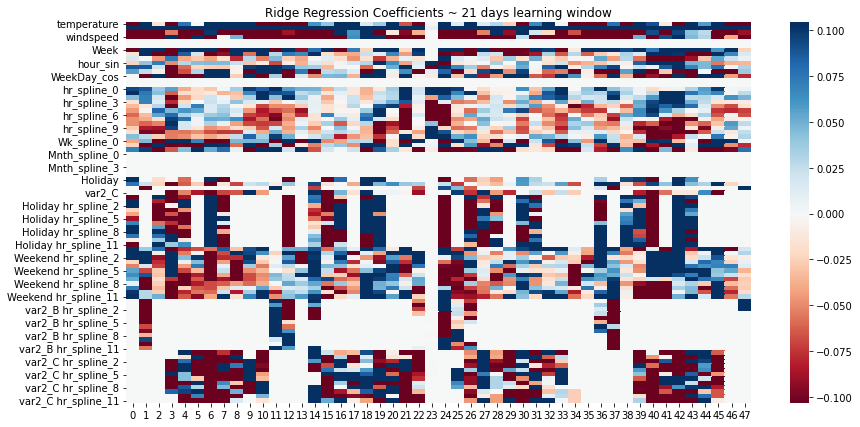

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
my_dpi= 300
fig, ax = plt.subplots(figsize=(4200/my_dpi,2100/my_dpi)) 
sns.heatmap(df4/df4.max(), vmin= df4.quantile(.05).quantile(.05), vmax= df4.quantile(.95).quantile(.95), ax=ax, center=0, cmap= 'RdBu')
plt.title('Ridge Regression Coefficients ~ 21 days learning window')
plt.savefig('11.RidgeCoeffs21days window.svg', bbox_inches='tight',fontsize = 20)

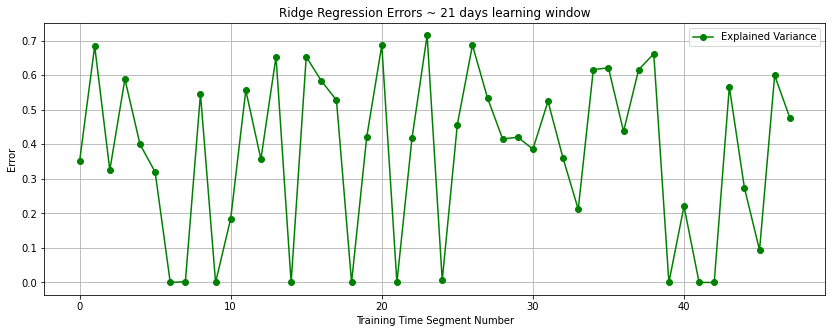

In [ ]:
my_dpi= 300
fig, ax = plt.subplots(figsize=(4200/my_dpi,1500/my_dpi)) 
# ax2 = ax.twinx()
# width = 0.4
# df5.plot(style='+')
# df5.MAE.plot(kind='line', color='red', ax=ax, marker='+', label= 'Mean Absolute Error')
# plt.legend()
# df5.MAPE.plot(kind='line', color='blue', ax=ax, marker='x', label= 'Mean Absolute Percentage Error')
df5.ExplainedVar.plot(kind='line', color='green', ax=ax, marker='o', label= 'Explained Variance')
plt.xlabel('Training Time Segment Number')
plt.ylabel('Error')
plt.legend()
plt.grid()
plt.title('Ridge Regression Errors ~ 21 days learning window')
plt.savefig('12.Error21days .svg', bbox_inches='tight',fontsize = 20)

In [ ]:
df6= pd.concat(trains, axis=0)
df7= pd.concat(tests, axis=0)

In [ ]:
df7.head()

,datetime,y_dash
0,2013-07-24 00:00:00,234.046066
1,2013-07-24 01:00:00,212.742325
2,2013-07-24 02:00:00,231.687584
3,2013-07-24 03:00:00,210.913365
4,2013-07-24 04:00:00,242.374605


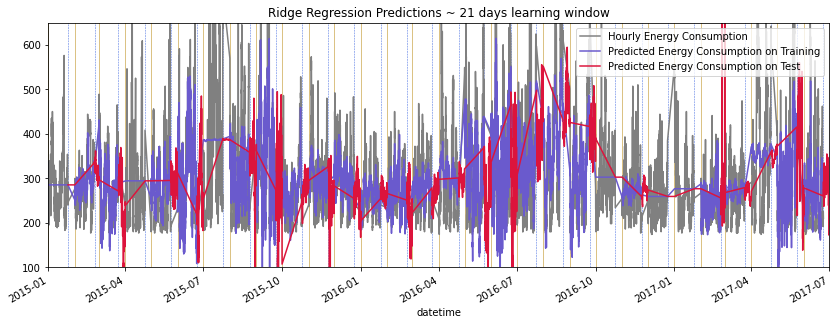

In [ ]:
my_dpi= 300
fig, ax = plt.subplots(figsize=(4200/my_dpi,1500/my_dpi)) 
df6.loc[df6.datetime >= '01-01-2015'].plot(x= 'datetime', y= 'electricity_consumption', ax=ax, color= 'gray', label='Hourly Energy Consumption')
df6.loc[df6.datetime >= '01-01-2015'].plot(x= 'datetime', y= 'y_dash', ax=ax, color= 'slateblue', label='Predicted Energy Consumption on Training')
df7.loc[df7.datetime >= '01-01-2015'].plot(x= 'datetime', y= 'y_dash', ax=ax, color= 'crimson', label='Predicted Energy Consumption on Test')
ax.vlines(x=df3.TestDateMin.tolist(), ymin= 100, ymax= 1400, colors='royalblue', ls='--', lw=.5, label='Lagging Time- Test')
ax.vlines(x=df3.TestDateMax.tolist(), ymin= 100, ymax= 1400, colors='darkgoldenrod', ls='-', lw=.5, label='Leading Time- Test')
plt.ylim(100, 650)
plt.xlim('01-01-2015', '07-01-2017')
plt.title('Ridge Regression Predictions ~ 21 days learning window')
plt.savefig('13.RidgePred21days.svg', bbox_inches='tight',fontsize = 20)